## EXERCISE 2

Visualize and clusterize the data in the file x_12d.dat (N=600 samples, L=12 dimensions), which also has labels for checking the performances (y_12d.dat).

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lucrezia | Rossi | 2122164 |
| Lorenzo | Calandra Buonaura | 2107761 |
| Andrea | Turci | 2106724 |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN
from sklearn.metrics import normalized_mutual_info_score

### 1\. “eps” (ε) and “minPts” (mP) in DBSCAN algorithm for clustering
Refine the grid with more values of ε and mP and plot a heat-map showing the normalized mutual information (NMI) between true and predicted clusters, similar to the one on the right.

Is the high NMI region showing a correlation between ε and mP?

Note: In the lesson we have looked at the typical distance between a point and its closest neighbor, but this does not say what the typical distance is from the 2nd, 3rd , ..., mP-neighbor. The plots of ranked distances to the i-th neighbor might also help choose the ε for a given i=mP .

In [2]:
fname, fnamey = "x_12d.dat", "y_12d.dat"
data = np.loadtxt("DATA/" + fname, delimiter='\t')
y = np.loadtxt("DATA/" + fnamey, dtype=int)

N = len(data)
D = len(data[0])
print(f"N = {N},    L = D = {D}")

x=data

N = 600,    L = D = 12


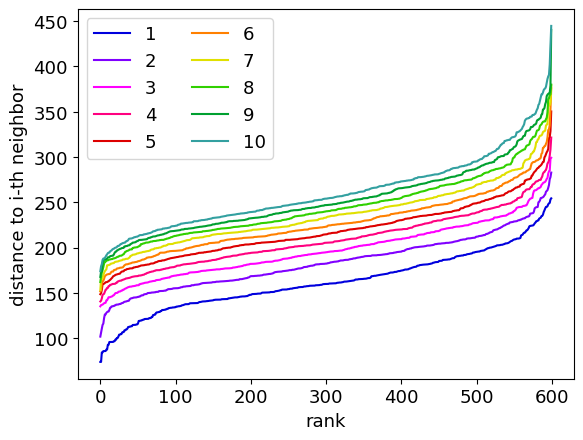

mean minimum distance between points:  162.34622464324366


In [3]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x)
dd=d.T
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()
mean_min_dist = np.mean(dd[1]) #dd[1] significa che prendiamo il primo vicino
print("mean minimum distance between points: ",mean_min_dist)

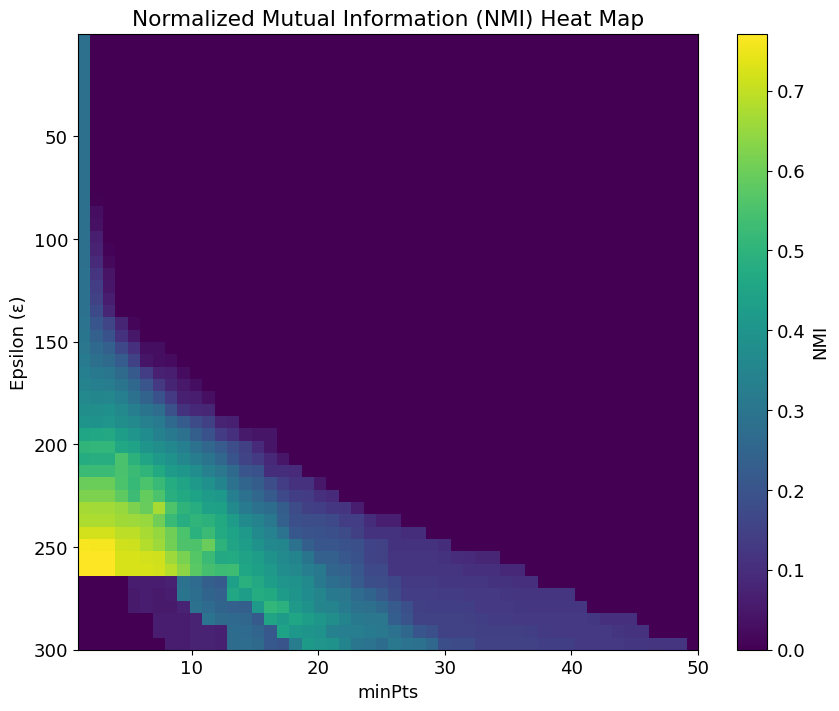

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
#X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
#eps_range = [r/2,r,1.5*r,2*r]

#min_sample_range = [2,3,5,10]
eps_range = np.linspace(0.1,300)  # Adjusted range for epsilon
min_sample_range = np.arange(1, 51)
i,j=0,0
nmi=1

# Initialize a matrix to store NMI values
nmi_matrix = np.zeros((len(eps_range), len(min_sample_range)))    
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        nmi=NMI(y_hat, y_true)
        # Store NMI value in the matrix
        nmi_matrix[i, j] = nmi
# Plot the heat map
plt.figure(figsize=(10, 8))
plt.imshow(nmi_matrix, cmap='viridis', aspect='auto', extent=[min_sample_range[0], min_sample_range[-1], eps_range[-1], eps_range[0]])
plt.colorbar(label='NMI')
plt.xlabel('minPts')
plt.ylabel('Epsilon (ε)')
plt.title('Normalized Mutual Information (NMI) Heat Map')
plt.show()


### 2\. Understanding the 12-dimensional data
Use the principal component analysis (PCA) to visualize the first components of the data. Does it help understand its structure?

### 3\. Compare different clustering methods
a) Perform a k-means clustering of the data, with k=3. Does it work better than DBSCAN? Why?

b) Perform a hierarchical clustering of the data and plot the corresponding dendrogram. 
Does it work better than DBSCAN?